# Numerical computation

## Digital computation of the fractional Fourier transform

The following algorithm proposed by [Haldun et al. in 1996](https://ieeexplore.ieee.org/abstract/document/536672/), takes advantage of the fractional Fourier transform (FrFT) as a member of the quadratic-phase transforms to broke down the transformation into simpler operations. Through this method, also known as fast approximate fractional Fourier transform, the samples of the transformed signal are obtained in terms of samples of the signal in a process whose computational complexity is $\mathcal{O}(N\log{N})$, where $N$ is the time-bandwidth product of the signal. 

In this algorith it is assumed that the time representation of the signal is confined to the interval $[-\Delta t/2, \Delta t/2]$ and the frequency domain representation is confined to the interval $[-\Delta f/2, \Delta f/2]$. The time-bandwidth product is defined as:

$$
N = \Delta t \Delta f.
$$

The time and frequency coordinates are normalized as 

$$
x = \frac{t}{s}
$$ 

and

$$
v = f s
$$

where

$$
s = \sqrt{\frac{\Delta t}{\Delta f}}
$$

Due to this normalization the lengths of the time and frequency intervals are now equal to the dimensionless quantity $\sqrt{\Delta f \Delta t} = \Delta x$ and the Wigner distribution is confined within a circle of diameter $\Delta x$. In the newly defined coordinates, the signal can be represented in time and frequency domains with $N = \Delta x^2$ samples spaced $\Delta x^{-1} = 1/\sqrt{N}$ apart.

To understand the mechanics of this implementation, let's recal the definition of the FrFT where the $a$th-order FrFT of a signal $f(x)$ is defined as follows:

$$
\mathcal{F}^a\{f(x)\} = f_a(x_a) = \int\limits_{-\infty}^\infty K_a(x,x_a) f(x) \mathrm{d}x.
$$

The kernel $K_a(x,x_a)$ is given by the following expression:

$$
K_a(x,x_a) = 
\left\{
\begin{aligned}
& A_\phi \exp{[i\pi(x_a^2 \cot{\phi} - 2 x_a x \csc{\phi} + x^2 \cot{\phi})]},\\
& \delta(x_a-x) \quad \text{if} \quad a \to 4n,\\
& \delta(x_a+x) \quad \text{if} \quad a \to 4n \pm 2,
\end{aligned}
\right.
$$

where $i^2=-1$, $n \in \mathbb{Z}$ and:

$$
A_\phi = \sqrt{1-i\cot{\phi}} = \frac{\exp{\left[-i \left(\frac{\pi \text{ sign}(\sin{\phi})}{4} - \frac{\phi}{2}\right)\right]}}{\sqrt{|\sin{\phi}|}},
$$

$$
\phi = \frac{a\pi}{2}.
$$


Given that the FrFT is a member of the linear canonical transforms, it can be broken down into a succession of simpler operations, such as chirp multiplication, chirp convolution, scaling, and ordinary Fourier transformation. Note that the kernel argument can be rewritten as

$$
\begin{aligned}
x_a^2 \cot{\phi} - 2 x_a x \csc{\phi} + x^2 \cot{\phi} &= x_a^2(\cot{\phi} - \csc{\phi}) + (x_a - x)^2 \csc{\phi} + x^2(\cot{\phi} - \csc{\phi}) \\
&= -x_a^2\tan(\phi/2) + (x_a - x)^2 \csc{\phi} - x^2\tan(\phi/2)
\end{aligned},
$$

given that $\cot{\phi} - \csc{\phi} = -\tan(\phi/2)$. Thus, for values of $a \neq 4n$ and $a \neq 4n \pm 2$,  the definition of the FrFT can be rewritten in the following form that can be seen as applying a chirp convolution with sweep rate $\csc{\phi}$ in between two chirp multiplications with sweep rate $\cot{\phi}$

$$
\mathcal{F}^a\{f(x)\} = A_\phi \exp{\left(-i\pi \tan(\phi/2) x_a^2\right)} \int\limits_{-\infty}^\infty \exp{\left(i\pi \csc{\phi} (x_a - x)^2 \right)} \left[ \exp{\left(-i\pi \tan(\phi/2) x^2\right)} f(x)\right] \mathrm{d}x.
$$


For a practical algorithm this definition is broken down in the following steps:

1. Chirp premultiplication:

$$
g(x) = \exp{\left(-i\pi \tan(\phi/2) x^2\right)} f(x)
$$

In this step the input signal $f(x)$ is multiplied by a chirp function which produces a shear in the Wigner distribution. As result of this step, the time-bandwidth product of $g(x)$ can be as large as twice of the input signal. Thus we require the samples of $g(x)$ spaced halfe the distance of the samples of $f(x)$. If the samples of $f(x)$ are spaced at $1/\Delta x$, we can perform an interpolation to obtain samples spaced $1/2 \Delta x$ and then multiply by the samples of the chirp function to obtain $g(x)$.

2. Chirp convolution:

$$
\begin{aligned}
g'(x_a) &= A_\phi \int\limits_{-\infty}^\infty \exp{\left(i\pi \csc{\phi} (x_a - x)^2 \right)} g(x) \mathrm{d}x \\
&= A_\phi \int\limits_{-\infty}^\infty h(x_a - x) g(x) \mathrm{d}x
\end{aligned}
$$

In this step $g(x)$ is convolved with a chirp function. To perform this convolution, we note that since $g(x)$ is bandlimited, the chirp function can also be replaced with its bandlimited version, that is

$$
h(x) = \int\limits_{-\Delta x}^{\Delta x} H(v) \exp{(i2pi v x)} \mathrm{d}v,
$$

where $H(v)$ is the Fourier transform of $\exp{(i2pi \csc{\phi} x^2)}$.

3. Chirp postmultiplication:

$$
f_a(x_a) = \exp{\left(-i\pi \tan(\phi/2) x_a^2\right)} g'(x_a)
$$

In this step the $g'(x_a)$ is multiplied by a chirp function.

The core of this implementation, can be written in its discrete form as:

$$
f_a\left(\frac{m}{2\Delta x}\right) = \frac{A_\phi}{2\Delta x} \exp{\left(-i\pi \tan{(\phi/2)} \left(\frac{m}{2\Delta x}\right)^2\right)} \sum_{n = -N}^{N-1} \exp{\left( i\pi \csc{\phi} \left(\frac{m-n}{2\Delta x}\right)^2 \right)} \left[\exp{\left(-i\pi \tan{(\phi/2)} \left(\frac{n}{2\Delta x}\right)^2\right)} f\left(\frac{n}{2\Delta x}\right)\right]
$$

with $n = \{-N, \dots, N - 1\}$. It can be recognized that the summation is the convolution of 

$$
\exp{\left( i\pi \csc{\phi} \left(\frac{n}{2\Delta x}\right)^2 \right)}
$$

and the the chirp-modulated function. This convolution can be computed in $\mathcal{O}(N\log{N})$ time by using the FFT

## Input signal (Example)

Consider the following chirp function (signal)

$$
f(t) = \exp{\left[i2\pi \left(\frac{ct^2}{2} + f_0t \right)\right]}
$$

with sweep rate $c$ defied as:

$$
c = \frac{f_1 - f_0}{T},
$$

where $T$ is the sweeping period. For this example let's use the following parameter

- $f_0 = 1$ Hz
- $f_1 = 20$ Hz
- $T = 1$ sec

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import fftconvolve

from dsp.signals.fm import lfmsig
from dsp.transforms.frft import frft, ifrft

sns.set_style("whitegrid")

In [3]:
fs = 500 # Sampling frequency
ds = 1/fs # Sampling period
dur = 1 # Duration

t = np.linspace(0,dur-ds,dur*fs) # Time instants

f0 = 0 # Instantaneous initial frequency
f1 = 20 # Instantaneous final frequency
T = 1 # Sweepping period
c = (f1-f0)/T # sweep rate

phi = 2*np.pi*(0.5*c*t**2 + f0*t)
x = np.exp(1j*(phi))

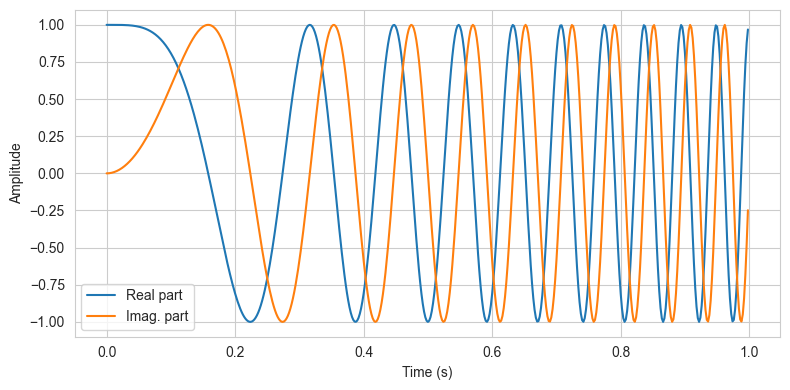

In [4]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(t, np.real(x), label='Real part')
ax.plot(t, np.imag(x), label='Imag. part')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

## Implementation details

Because the FrFT can be computed for a value of $a$ modulo 4, and by using further additivity properties of $a$, it can be reduced to the interval $0.5 < a < 1.5$ by first replacing $a$ by the residual of $a/4$, reducing the interval to $0 \leq a < 4$. This interval is further reduced to $0 \leq a \leq 2$ by using $\mathcal{F}^a = \mathcal{F}^2 \mathcal{F}^{a-2}$ if $a > 2$. Note that $\mathcal{F}^2$ just reverses the input signal and is thus a trivial operation. Finaly the following test is perform:

- If $a > 1.5$ then $\mathcal{F}^a = \mathcal{F}\mathcal{F}^{a-1}$.
- If $a > 0.5$ then $\mathcal{F}^a = \mathcal{F}^{-1}\mathcal{F}^{a+1}$.

Classically the FFT is defined as a transformation of a vector $[f(0), \dots, f(N - 1)]$. This differ with the above definition for the Fast approximate FrFT, where the signal is assumed to be $[f(-N), \dots, f(N - 1)]$. To vercome this issue, the input signal must be cyclically shifted over (approximately) half the signal length. For example, if the length $N$ of the signal is even, then the FFT should be computed as $\mathcal{SFS}f$, where $\mathcal{S}$ is the cyclic shift over $N/2$ samples.

As The band-width in the chirp multiplication can be doubled, we need to double the number of samples to avoid aliassing. A similar argument holds for the convolution. Therefore a longer signal need to be obtained by interpolation. A solutión to this can be achieved by using sinc interpolation to double the length of the signal and then apply zero padding o obtain a signal of length $4N$. The sinc interpolant of $f$ for the interpolation points $\{x_k = k/2\Delta x: k = -N, \dots, N-1\}$ is given by:

$$
y(x) = \sum_{k = -N}^{N - 1} f(x_k) \text{ sinc}(2 \Delta(x - x_k))
$$

Thus it can be computed by either a convolution of the signal with a sinc function or it can be applied explicitly using the FFT and its inverse.

In [5]:
# Signal length
N = len(x)
print('Signal length = ', N)

# FrFT order
s = np.sqrt(N)/fs
dx = dur/s
df = (f1-f0)*s

a = (2/np.pi)*np.arctan(df/dx) + 1
print('aopt = ', a)

Signal length =  500
aopt =  1.0254512226959838


In [6]:
# Reduce the order to the interval [0, 4)
a = a % 4
print('a = ', a)

# Normalization term
sN = np.sqrt(N)
print('Normalization term = ', sN)

# Cyclically shifted samples for even and odd N
shft = ((np.arange(N) + np.fix(N/2)) % N).astype(int)
print('Cyclically shifted samples: \n', shft)

a =  1.0254512226959838
Normalization term =  22.360679774997898
Cyclically shifted samples: 
 [250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321
 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411
 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429
 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447
 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 

In [7]:
# Perform special cases, a = 0, 1, 2, 3
fa = np.zeros_like(x, dtype=np.complex128())

if a == 0.0:
    fa = x
if a == 2.0:
    fa = np.flipud(x)
if a == 1.0:
    fa[shft] = np.fft.fft(x[shft]) / sN
if a == 3.0:
    fa[shft] = np.fft.ifft(x[shft]) * sN

In [8]:
# Reduce the order to the interval [0.5, 1.5]
if a > 2.0:
    a = a - 2.0
    x = np.flipud(x)
if a > 1.5:
    a = a - 1
    x[shft] = np.fft.fft(x[shft]) / sN
if a < 0.5:
    a = a + 1
    x[shft] = np.fft.ifft(x[shft]) * sN

In [9]:
# Rotation angle
phi = a * np.pi / 2
print('phi = ', phi)

phi =  1.6107750139181867


In [10]:
# Interpolation and zero padding
y = np.zeros(2 * N - 1, dtype=x.dtype)
y[:2 * N:2] = x
xint = fftconvolve(y[:2 * N], np.sinc(np.arange(-(2 * N - 3), (2 * N - 2)).T / 2))
xint = xint[2 * N - 3: -2 * N + 3]
x = np.hstack((np.zeros(N - 1), xint, np.zeros(N - 1))).T
print('Interpolated and zeropadded signal length: ', len(x))

Interpolated and zeropadded signal length:  1997


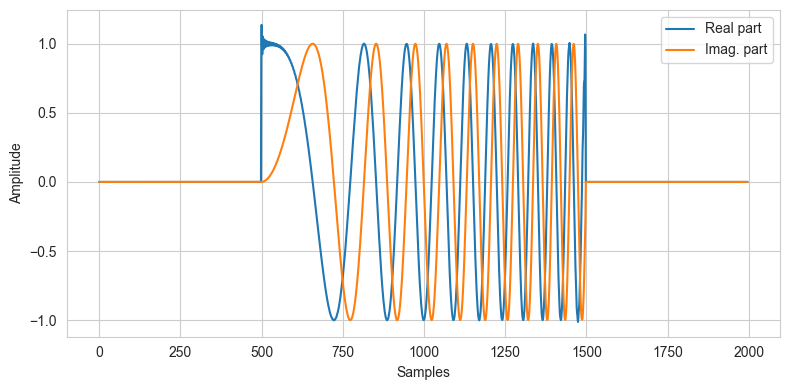

In [11]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.real(x), label='Real part')
ax.plot(np.imag(x), label='Imag. part')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
# Chirp premultiplication
tana2 = np.tan(phi / 2)
n = np.arange(-2 * N + 2, 2 * N - 1)
chrp = np.exp(-1j * np.pi * tana2 / (4 * N) * n**2)
x = chrp * x

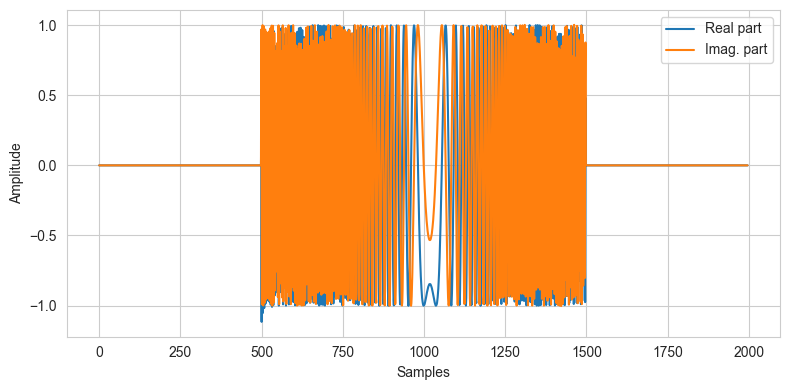

In [13]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.real(x), label='Real part')
ax.plot(np.imag(x), label='Imag. part')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# chirp convolution
csca = 1/np.sin(phi)
m = np.arange(-(4 * N - 4), 4 * N - 3)
chrpc = np.exp(1j * np.pi * csca / (4 * N) * m**2)
x = fftconvolve(chrpc, x)
x = x[4 * N - 4:8 * N - 7] * np.sqrt(csca / (4 * N))

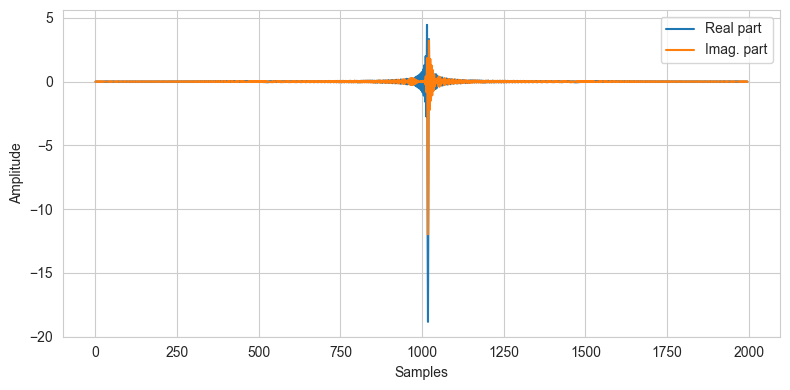

In [15]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.real(x), label='Real part')
ax.plot(np.imag(x), label='Imag. part')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Chirp post multiplication
x = chrp * x

# Normalizing constant
xa = np.exp(-1j * (1 - a) * np.pi / 4) * x[N - 1:-N + 1:2]

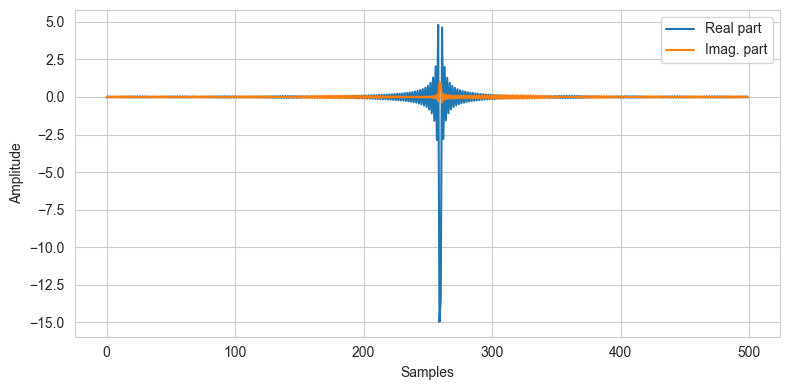

In [17]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.real(xa), label='Real part')
ax.plot(np.imag(xa), label='Imag. part')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

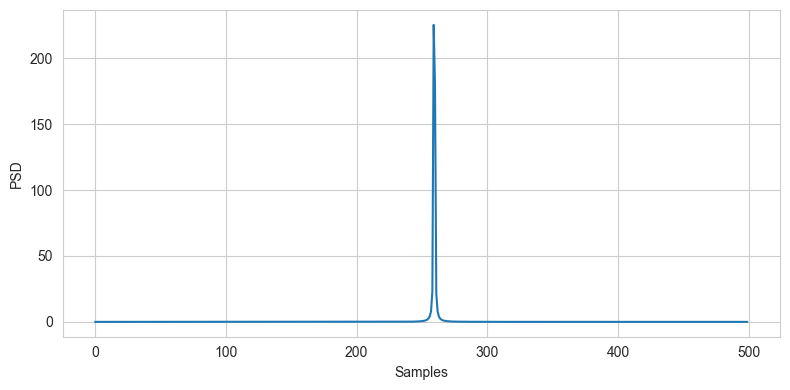

In [18]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.abs(xa)**2)
ax.set_xlabel('Samples')
ax.set_ylabel('PSD')
plt.tight_layout()
plt.show()

## Precision testing

In [19]:
fs = 1000
dur = 1
t = np.linspace(0, dur, fs)

f0 = 150
f1 = 0
T = 1
x = lfmsig(t, f0=f0, f1=f1, sweep_time=T)
N = len(x)

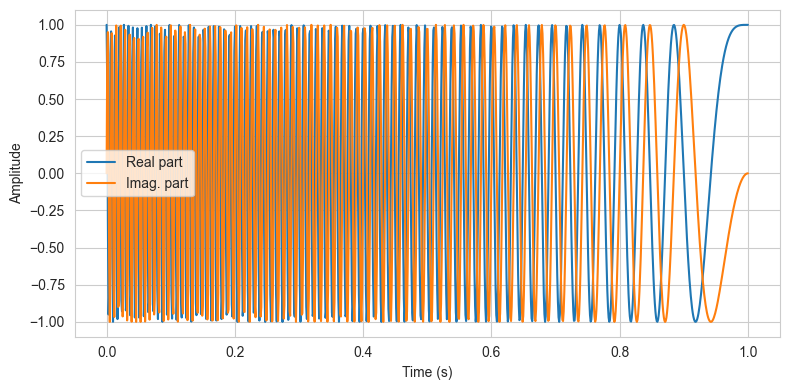

In [20]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(t, np.real(x), label='Real part')
ax.plot(t, np.imag(x), label='Imag. part')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
s = np.sqrt(N)/fs
dx = dur/s
df = (f1-f0)*s

a = (2/np.pi)*np.arctan(df/dx) + 1
print('aopt = ', a)

xa = frft(x, a)

aopt =  0.9052137154450207


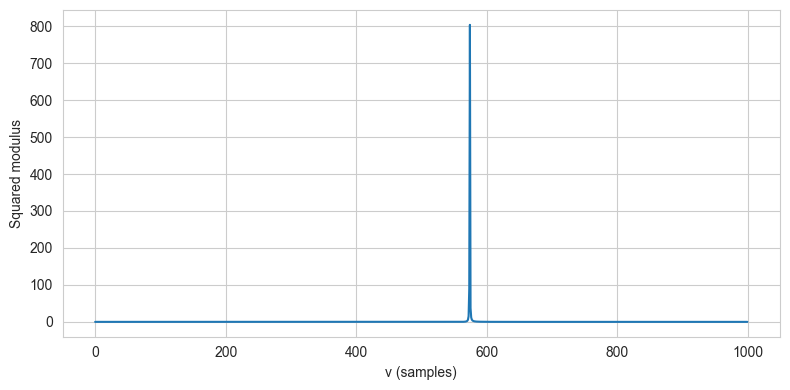

In [22]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.abs(xa)**2)
ax.set_xlabel('v (samples)')
ax.set_ylabel('Squared modulus')
plt.tight_layout()
plt.show()

In [23]:
y = ifrft(xa, -a)
err = np.abs(x - y)

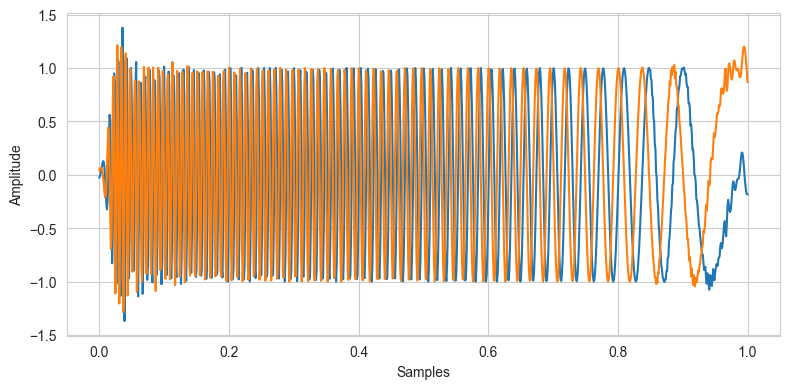

In [24]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(t, np.real(y), label='Real part')
ax.plot(t, np.imag(y), label='Imag. part')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

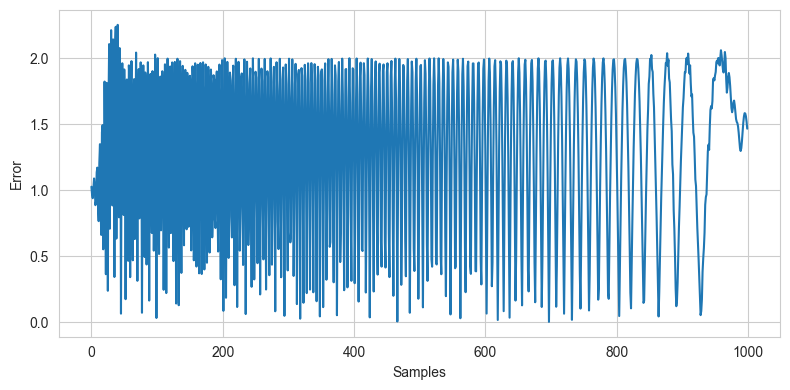

In [25]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(err)
ax.set_xlabel('Samples')
ax.set_ylabel('Error')
plt.tight_layout()
plt.show()